## CIFAR100 데이터 로드

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 데이터 변환 정의 (텐서 변환 + 정규화)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-100 학습 데이터셋 로드 (테스트 데이터 불필요)
train_dataset = torchvision.datasets.CIFAR100(
    root="./data", train=True, download=True, transform=transform
)

# DataLoader 생성
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


Files already downloaded and verified


## GAN 모델 정의

In [4]:
import os
import torch.nn as nn
import torch.optim as optim

# Generator 정의
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 512 * 4 * 4),
            nn.BatchNorm1d(512 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (512, 4, 4)),  # (512, 4, 4)

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # (256, 8, 8)
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1),  # (3, 32, 32)
            nn.Tanh()  # 픽셀 값 [-1, 1] 범위로 조정
        )

    def forward(self, z):
        return self.gen(z)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=4, stride=2, padding=1),  # (128, 16, 16)
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # (256, 8, 8)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # (512, 4, 4)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1),
            nn.Sigmoid()  # 진짜/가짜 확률 출력
        )

    def forward(self, img):
        return self.disc(img)


## 파라미터 설정

In [8]:
z_dim = 100  # 노이즈 벡터 차원
lr = 0.0003
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 초기화 및 설정
generator = Generator(z_dim).to(device)
discriminator = Discriminator().to(device)

# 손실 함수 및 옵티마이저 설정
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


# 학습 루프 (손실값 저장 추가)
os.makedirs("gan_images", exist_ok=True)  # 생성 이미지 저장 폴더
loss_G_list, loss_D_list = [], []  # 손실값 저장 리스트

## 학습

In [9]:
for epoch in range(epochs):
    for batch_idx, (real_imgs, _) in enumerate(train_loader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.shape[0]

        # Discriminator 학습 (진짜 vs 가짜)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        real_preds = discriminator(real_imgs)
        real_loss = criterion(real_preds, real_labels)

        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = generator(z)
        fake_preds = discriminator(fake_imgs.detach())
        fake_loss = criterion(fake_preds, fake_labels)

        d_loss = real_loss + fake_loss
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Generator 학습 (Discriminator를 속이도록)
        fake_preds = discriminator(fake_imgs)
        g_loss = criterion(fake_preds, real_labels)  # Generator는 가짜를 진짜로 만들고 싶음

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    # 손실값 저장
    loss_D_list.append(d_loss.item())
    loss_G_list.append(g_loss.item())

    # 에포크마다 생성 이미지 저장
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            z = torch.randn(16, z_dim).to(device)
            sample_imgs = generator(z).cpu()
            sample_imgs = (sample_imgs + 1) / 2  # [-1, 1] → [0, 1] 변환

            grid = torchvision.utils.make_grid(sample_imgs, nrow=4)
            plt.imshow(grid.permute(1, 2, 0))
            plt.axis("off")
            plt.savefig(f"gan_images/epoch_{epoch + 1}.png")
            plt.close()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

Epoch [1/50] | D Loss: 0.1136 | G Loss: 4.7865
Epoch [2/50] | D Loss: 0.3002 | G Loss: 3.0822
Epoch [3/50] | D Loss: 0.0305 | G Loss: 10.1004
Epoch [4/50] | D Loss: 0.0179 | G Loss: 6.0762
Epoch [5/50] | D Loss: 0.3869 | G Loss: 3.8889
Epoch [6/50] | D Loss: 0.2916 | G Loss: 3.2075
Epoch [7/50] | D Loss: 0.2455 | G Loss: 7.1481
Epoch [8/50] | D Loss: 0.6625 | G Loss: 1.2989
Epoch [9/50] | D Loss: 0.3298 | G Loss: 2.7187
Epoch [10/50] | D Loss: 0.1010 | G Loss: 4.7742
Epoch [11/50] | D Loss: 0.0990 | G Loss: 4.5685
Epoch [12/50] | D Loss: 0.2299 | G Loss: 3.4852
Epoch [13/50] | D Loss: 0.4856 | G Loss: 2.9959
Epoch [14/50] | D Loss: 0.1973 | G Loss: 4.2397
Epoch [15/50] | D Loss: 0.4395 | G Loss: 2.4210
Epoch [16/50] | D Loss: 0.2456 | G Loss: 6.0085
Epoch [17/50] | D Loss: 0.0590 | G Loss: 5.2371
Epoch [18/50] | D Loss: 0.8590 | G Loss: 10.0167
Epoch [19/50] | D Loss: 0.1860 | G Loss: 4.5986
Epoch [20/50] | D Loss: 0.6200 | G Loss: 8.1380
Epoch [21/50] | D Loss: 0.0452 | G Loss: 6.1289

## 학습 결과 시각화

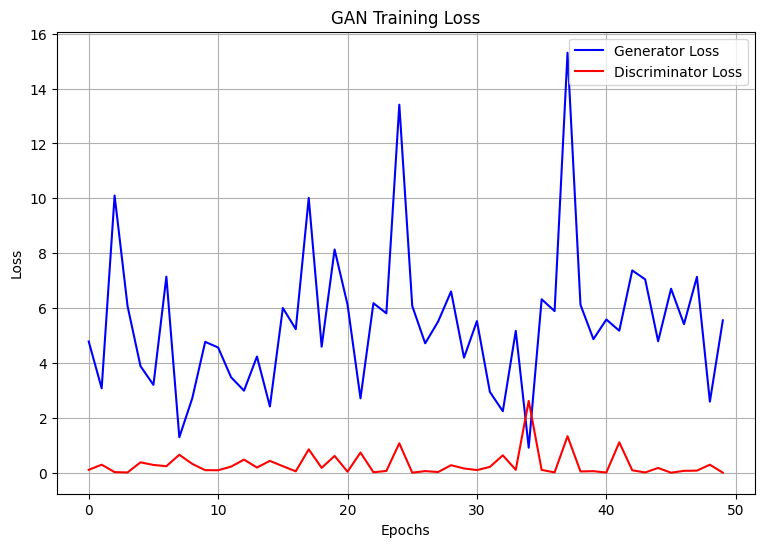

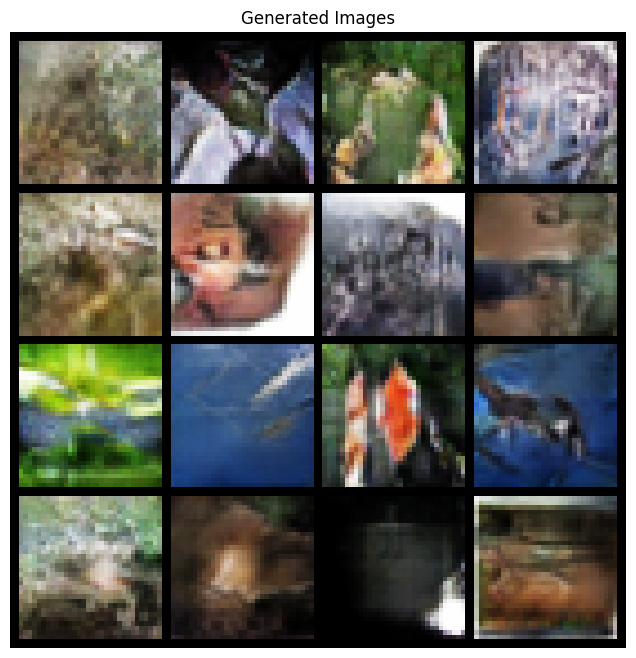

In [12]:
import torchvision.utils as vutils

# 손실 그래프 시각화
def plot_loss_curve(loss_G_list, loss_D_list, save_path="gan_images/loss_plot.png"):
    plt.figure(figsize=(9, 6))
    plt.plot(loss_G_list, label="Generator Loss", color='blue')
    plt.plot(loss_D_list, label="Discriminator Loss", color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("GAN Training Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()



# 학습된 Generator로 새로운 이미지 생성
def generate_images(generator, z_dim, device, save_path="gan_images/generated_samples.png"):
    generator.eval()  # 평가 모드
    with torch.no_grad():
        z = torch.randn(16, z_dim).to(device)  # 랜덤 노이즈 생성
        generated_images = generator(z).cpu()
        generated_images = (generated_images + 1) / 2  # [-1,1] → [0,1] 범위 변환

    # 생성된 이미지 시각화
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(vutils.make_grid(generated_images, nrow=4).permute(1, 2, 0))  # (C, H, W) → (H, W, C)
    plt.savefig(save_path)
    plt.show()

# 손실 그래프 & 생성 이미지 출력 실행
plot_loss_curve(loss_G_list, loss_D_list)  # 손실 그래프 출력
generate_images(generator, z_dim, device)  # 생성된 샘플 이미지 출력

## CGAN 모델 정의

In [5]:
# CGAN Generator 정의
class CGAN_Generator(nn.Module):
    def __init__(self, z_dim, class_dim):
        super(CGAN_Generator, self).__init__()
        self.fc_label = nn.Linear(class_dim, 100)  # 클래스 정보를 100차원으로 변환
        self.gen = nn.Sequential(
            nn.Linear(z_dim + 100, 512 * 4 * 4),
            nn.BatchNorm1d(512 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (512, 4, 4)),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # [-1, 1] 범위
        )

    def forward(self, z, labels):
        labels = self.fc_label(labels)  # 클래스 정보 변환
        x = torch.cat([z, labels], dim=1)  # 노이즈와 결합
        x = self.gen(x)
        return x

# CGAN Discriminator 정의
class CGAN_Discriminator(nn.Module):
    def __init__(self, class_dim):
        super(CGAN_Discriminator, self).__init__()
        self.fc_label = nn.Linear(class_dim, 32 * 32)  # 클래스 정보를 이미지 크기로 변환
        self.disc = nn.Sequential(
            nn.Conv2d(4, 128, kernel_size=4, stride=2, padding=1),  # 입력 채널 4개 (RGB + class 정보)
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        labels = self.fc_label(labels).view(-1, 1, 32, 32)
        x = torch.cat([img, labels], dim=1)  # 이미지와 클래스 정보 결합
        x = self.disc(x)
        return x


## 파라미터 설정

In [6]:
z_dim = 100  # 노이즈 차원
class_dim = 100
lr = 0.0003
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 초기화
generator = CGAN_Generator(z_dim, class_dim).to(device)
discriminator = CGAN_Discriminator(class_dim).to(device)

# 손실 함수 및 옵티마이저
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

## 모델 학습

In [7]:
# 학습 루프 (손실값 저장)
os.makedirs("cgan_images", exist_ok=True)
loss_G_list, loss_D_list = [], []

for epoch in range(epochs):
    for real_imgs, labels in train_loader:
        real_imgs, labels = real_imgs.to(device), labels.to(device)
        labels_onehot = torch.eye(class_dim, device=device)[labels]   # One-hot encoding

        # Discriminator 학습
        batch_size = real_imgs.size(0)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        real_preds = discriminator(real_imgs, labels_onehot)
        real_loss = criterion(real_preds, real_labels)

        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = generator(z, labels_onehot)
        fake_preds = discriminator(fake_imgs.detach(), labels_onehot)
        fake_loss = criterion(fake_preds, fake_labels)

        d_loss = real_loss + fake_loss
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Generator 학습
        fake_preds = discriminator(fake_imgs, labels_onehot)
        g_loss = criterion(fake_preds, real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    loss_D_list.append(d_loss.item())
    loss_G_list.append(g_loss.item())

    # 10 에포크마다 생성 이미지 저장
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
          z = torch.randn(16, z_dim).to(device)  # 랜덤 노이즈 생성
          random_labels = torch.randint(0, class_dim, (16,), device=device)  # 랜덤 클래스 선택
          labels_onehot = torch.eye(class_dim, device=device)[random_labels]  # One-hot Encoding 변환

          sample_imgs = generator(z, labels_onehot).cpu()  # labels 추가
          sample_imgs = (sample_imgs + 1) / 2  # [-1, 1] → [0, 1] 변환

          grid = torchvision.utils.make_grid(sample_imgs, nrow=4)
          plt.imshow(grid.permute(1, 2, 0))
          plt.axis("off")
          plt.savefig(f"cgan_images/epoch_{epoch + 1}.png")
          plt.close()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

Epoch [1/50] | D Loss: 0.2181 | G Loss: 7.1741
Epoch [2/50] | D Loss: 0.2457 | G Loss: 4.1477
Epoch [3/50] | D Loss: 0.2088 | G Loss: 4.2528
Epoch [4/50] | D Loss: 0.5303 | G Loss: 7.3273
Epoch [5/50] | D Loss: 0.7082 | G Loss: 2.1787
Epoch [6/50] | D Loss: 2.2350 | G Loss: 1.1807
Epoch [7/50] | D Loss: 0.1067 | G Loss: 5.2385
Epoch [8/50] | D Loss: 0.0429 | G Loss: 4.2563
Epoch [9/50] | D Loss: 0.1370 | G Loss: 4.8519
Epoch [10/50] | D Loss: 0.5793 | G Loss: 4.6839
Epoch [11/50] | D Loss: 0.0931 | G Loss: 3.6731
Epoch [12/50] | D Loss: 0.4720 | G Loss: 3.1540
Epoch [13/50] | D Loss: 0.4990 | G Loss: 1.9906
Epoch [14/50] | D Loss: 0.1975 | G Loss: 3.5256
Epoch [15/50] | D Loss: 0.2685 | G Loss: 4.0316
Epoch [16/50] | D Loss: 0.7374 | G Loss: 14.1764
Epoch [17/50] | D Loss: 0.1095 | G Loss: 4.4967
Epoch [18/50] | D Loss: 0.2054 | G Loss: 5.4556
Epoch [19/50] | D Loss: 0.0813 | G Loss: 4.6649
Epoch [20/50] | D Loss: 0.0977 | G Loss: 7.9441
Epoch [21/50] | D Loss: 0.1177 | G Loss: 3.8255


## 학습 결과 시각화

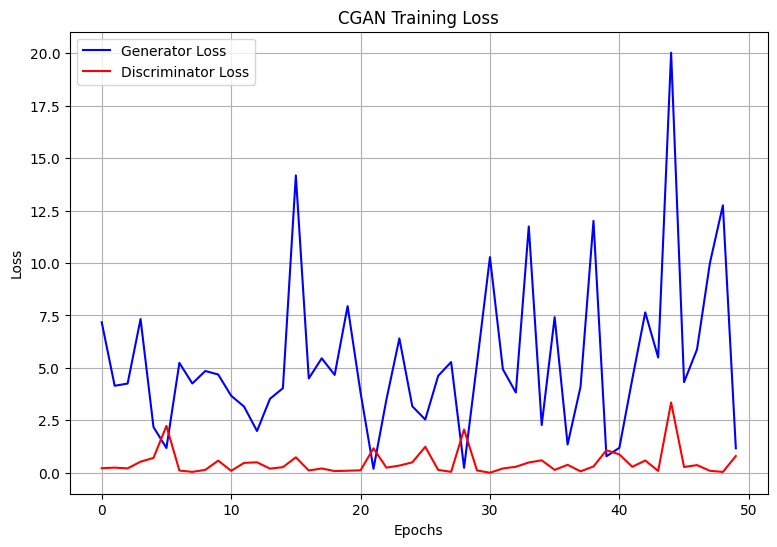

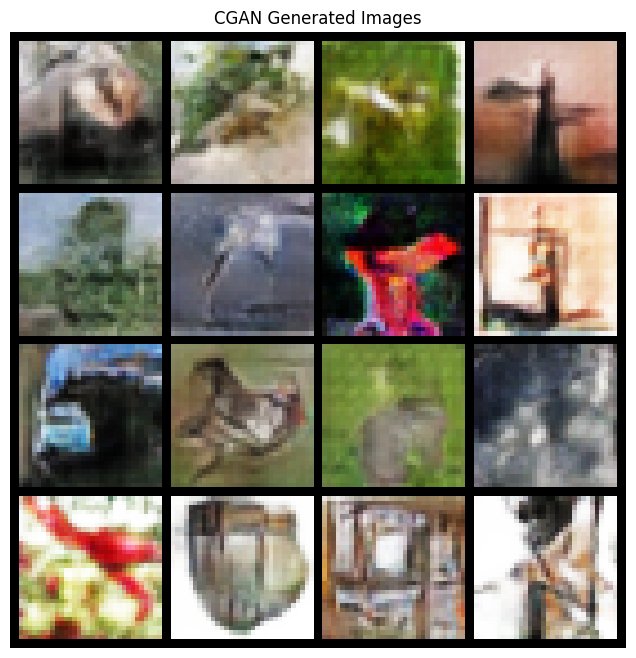

In [9]:
import torchvision.utils as vutils

# 손실 그래프 시각화
def plot_gan_loss(loss_G_list, loss_D_list, save_path="cgan_images/loss_plot.png"):
    plt.figure(figsize=(9, 6))
    plt.plot(loss_G_list, label="Generator Loss", color='blue')
    plt.plot(loss_D_list, label="Discriminator Loss", color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("CGAN Training Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()


# 학습된 CGAN Generator로 새로운 이미지 생성 (CGAN)
def generate_cgan_images(generator, z_dim, class_dim, device, save_path="cgan_images/generated_samples.png"):
    generator.eval()  # 평가 모드
    with torch.no_grad():
        z = torch.randn(16, z_dim).to(device)  # 랜덤 노이즈 생성
        random_labels = torch.randint(0, class_dim, (16,), device=device)  # 랜덤 클래스 선택
        labels_onehot = torch.eye(class_dim, device=device)[random_labels]  # One-hot Encoding 변환

        generated_images = generator(z, labels_onehot).cpu()  #  labels 추가 (오류 해결)
        generated_images = (generated_images + 1) / 2  # [-1,1] → [0,1] 변환

    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("CGAN Generated Images")
    plt.imshow(vutils.make_grid(generated_images, nrow=4).permute(1, 2, 0))  # (C, H, W) → (H, W, C)
    plt.savefig(save_path)
    plt.show()

# 손실 그래프 & 생성 이미지 출력
plot_gan_loss(loss_G_list, loss_D_list)
generate_cgan_images(generator, z_dim, class_dim, device)

## 실험 정리 및 결과 분석

## 실험정리

### 1. 데이터셋
- CIFAR-100 데이터셋

	•	100개의 클래스, 각 클래스당 600개의 32x32 RGB 이미지

	•	훈련 데이터 50,000개, 테스트 데이터 10,000개

	•	다양한 사물, 동물, 자연 이미지 포함

### 2. 모델 구조
- (1) GAN 구조

	•	Generator (G): 랜덤 노이즈를 입력으로 받아 이미지를 생성

	•	Discriminator (D): 입력된 이미지가 실제 이미지인지 판별하는 CNN 기반 모델

	•	학습 과정:

	1.	Discriminator 학습 → 실제 이미지는 1, 생성 이미지는 0이 되도록 학습
	2.	Generator 학습 → 생성된 이미지를 Discriminator가 진짜로 판단하도록 업데이트

- (2) CGAN 구조

	•	Generator (G): 기존 GAN의 Generator 구조에 클래스 정보를 추가 입력

	•	Discriminator (D): 입력된 이미지에 해당 클래스 정보가 포함되어 있는지 판별하도록 설계

	•	학습 과정:

	•	GAN과 동일하지만, 각 샘플에 클래스 정보를 추가 입력하여 클래스별 이미지 생성을 유도


3. 실험 결과 및 분석

- 1. 학습 과정 비교 (Loss 그래프 분석)

	•	GAN과 CGAN 모두 초기 학습 단계에서 Loss 변화가 크지만, 점진적으로 안정화되는 경향을 보임.

	•	Generator Loss가 지속적으로 증가하는 경향을 보이는 것은 Discriminator가 점점 더 좋은 판별로 진행중인 것으로 보임.

	•	Discriminator Loss는 일정 수준에서 유지되는 경향을 보이며, 이는 학습이 정상적으로 진행되고 있음을 의미.

- 2. 생성 이미지 비교

	•	GAN으로 생성된 이미지는 전반적으로 흐릿하고 의미 없는 패턴이 포함되어 있으며, 특정 객체의 형상이 명확하지 않음지만 CGAN으로 생성된 이미지는 보다는 조금 더 구체적인 형태를 가지고 있음.



